<a href="https://colab.research.google.com/github/zhiyingli97/ExplainMAE/blob/main/Adver_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')

import models_mae

Running in Colab.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'mae' already exists and is not an empty directory.


In [ ]:
! pip install captum
! pip install torchshow
! pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from captum.attr import (
    GuidedGradCam,
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
    Saliency,
    Occlusion,
    LRP,
    GuidedBackprop
)
device='cuda'

In [ ]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_base_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

# Load Images

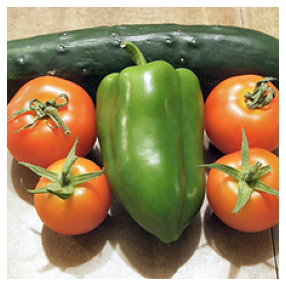

In [ ]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_base_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

# load an image
img1_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
img2_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851

img1 = Image.open(requests.get(img1_url, stream=True).raw)
img1 = img1.resize((224, 224))
img1 = np.array(img1) / 255.
assert img1.shape == (224, 224, 3)
# normalize by ImageNet mean and std
img1 = img1 - imagenet_mean
img1 = img1 / imagenet_std
plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img1))

img2 = Image.open(requests.get(img2_url, stream=True).raw)
img2 = img2.resize((224, 224))
img2 = np.array(img2) / 255.
assert img2.shape == (224, 224, 3)
# normalize by ImageNet mean and std
img2 = img2 - imagenet_mean
img2 = img2 / imagenet_std
plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img2))

In [ ]:
def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")
    
    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

In [ ]:
# Load Model
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_base.pth

chkpt_dir = 'mae_visualize_vit_base.pth'
# chkpt_dir = '/content'
model_mae = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
print('Model loaded.')

File ‘mae_visualize_vit_base.pth’ already there; not retrieving.

<All keys matched successfully>
Model loaded.


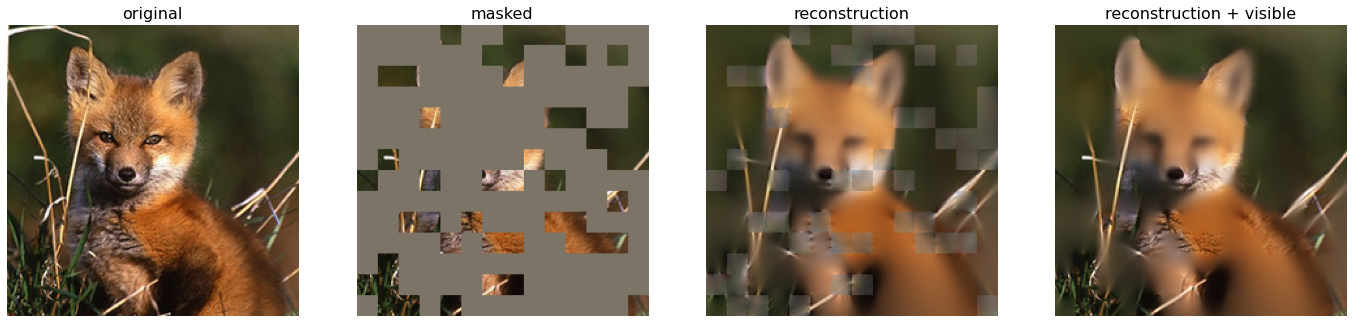

In [ ]:
run_one_image(img1, model_mae)

In [ ]:
x = torch.tensor(img1)

# make it a batch-like
x = x.unsqueeze(dim=0)
x = torch.einsum('nhwc->nchw', x)

# run MAE
loss, y, mask = model_mae(x.float(), mask_ratio=0.75)

# Finetune

In [ ]:
import torch.nn as nn

class FT_Adapter(nn.Module):
    """
    Adapter for Active Finetune
    """

    def __init__(self, embed_dim=1024,num_classes=10,reduction=2,adapter_type='MLP'):
        super(FT_Adapter,self).__init__()
        self.embed_dim = embed_dim
        self.adapter_type = adapter_type


        if adapter_type == 'MLP':
            self.adapter = nn.Sequential(
                nn.Linear(embed_dim, embed_dim // reduction),
                nn.ReLU(inplace=False),
                nn.Linear(embed_dim // reduction, embed_dim),
                nn.ReLU(inplace=False)
            )
        self.classifier = nn.Linear(embed_dim,num_classes,bias=False)

    def forward_emb(self,x):
        """
         x -> [batch_size, dim]
        """
        out = self.adapter(x)
        return out

    def forward(self,x):
        """
         x -> [batch_size, dim]
        """
        out = self.forward_emb(x)
        out = self.classifier(x)
        return out
    
    def forward_all(self,x):
        batch_size = x.shape[0]
        patch_num = x.shape[1]
        x = x.reshape([batch_size*patch_num,-1])
        x = self.adapter(x)
        out = x.reshape([batch_size,patch_num,-1])
        return out

class CombineModel(nn.Module):
    """
    Combine Adapter and MAE
    """

    def __init__(self, model, adapter,use_global_avg):
        super(CombineModel,self).__init__()
        self.model = model
        self.adapter = adapter
        self.use_global_avg = use_global_avg
    
    def forward(self,x):
        out,_,_ = self.model.forward_encoder(x,0)
        if self.use_global_avg:
            out = out[:, 1:, :].mean(dim=1)
        else:
            out = out[:, 0]
        out = self.adapter(out)
        return out

# CIFAR10

In [ ]:

# load data
input_size = 224
import torchvision.transforms as transforms
import torchvision.datasets as datasets
train_num = 1000

transform = transforms.Compose([
            transforms.Resize(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
train_dataset = datasets.CIFAR10(
    root = './cifar10',
    train = True,
    transform=transform,
    download=True
) 

train_dataset,_ = torch.utils.data.random_split(train_dataset,[train_num,len(train_dataset)-train_num])


test_dataset = datasets.CIFAR10(
    root = './cifar10',
    train = False,
    transform=transform,
    download=True
) 

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=28
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=28
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
"""
Finetune
"""
def accuracy(output, target, topk=(1,)):
    
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

# load model
model_mae = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
model_mae.eval()
model_mae.to(device)
adapter = FT_Adapter(embed_dim=768,num_classes=10)
adapter.to(device)
optimizer = torch.optim.Adam(adapter.parameters(),lr=0.001)
use_global_avg = True
criterion = torch.nn.CrossEntropyLoss()
epoch_num = 20
acc_lst = []

for epoch in range(epoch_num):
  acc = 0
  for i, (input, target) in enumerate(train_dataloader):
    input, target = input.to(device), target.to(device)
    with torch.no_grad():
      feats,_,_ = model_mae.forward_encoder(input,0)
      if use_global_avg:
        feats = feats[:, 1:, :].mean(dim=1)
      else:
        feats = feats[:, 0]

    pre = adapter(feats)
    loss = criterion(pre, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc += accuracy(pre, target)[0]
  acc = acc / (i+1)
  acc_lst.append(acc.item())
  print('Epoch: '+str(epoch))
  print('Acc: ' + str(acc.item()))


<All keys matched successfully>
Epoch: 0
Acc: 24.285715103149414
Epoch: 1
Acc: 44.14683151245117
Epoch: 2
Acc: 55.35714340209961
Epoch: 3
Acc: 60.2579345703125
Epoch: 4
Acc: 64.6031723022461
Epoch: 5
Acc: 66.54761505126953
Epoch: 6
Acc: 68.82936096191406
Epoch: 7
Acc: 70.75396728515625
Epoch: 8
Acc: 72.61905670166016
Epoch: 9
Acc: 73.21429443359375
Epoch: 10
Acc: 74.1468276977539
Epoch: 11
Acc: 75.07937622070312
Epoch: 12
Acc: 75.71428680419922
Epoch: 13
Acc: 76.6071548461914
Epoch: 14
Acc: 77.20237731933594
Epoch: 15
Acc: 77.59920501708984
Epoch: 16
Acc: 78.13491821289062
Epoch: 17
Acc: 79.02777099609375
Epoch: 18
Acc: 79.9206314086914
Epoch: 19
Acc: 80.31745147705078


Text(0, 0.5, 'Acc')

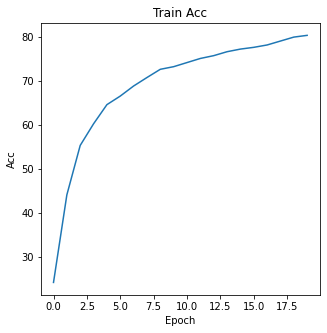

In [ ]:
plt.figure(figsize=[5,5])
plt.plot([i for i in range(epoch_num)],acc_lst)
plt.title('Train Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')

In [ ]:
vis_num = 5
com_model = CombineModel(model_mae,adapter,False)

imgs,labels = next(iter(test_dataloader))
imgs = imgs[:vis_num].cuda()
labels = labels[:vis_num].cuda()

# # ig
# ig = IntegratedGradients(com_model)
# attribution_ig = ig.attribute(imgs, target=labels)

# saliency
saliency = Saliency(com_model)
attribution_saliency = saliency.attribute(imgs, target=labels)

# gdp
gbp = GuidedBackprop(com_model)
attribution_gdp = gbp.attribute(imgs, target=labels)

# deeplift
dl = DeepLift(com_model)
attribution_dl = dl.attribute(imgs, target=labels)

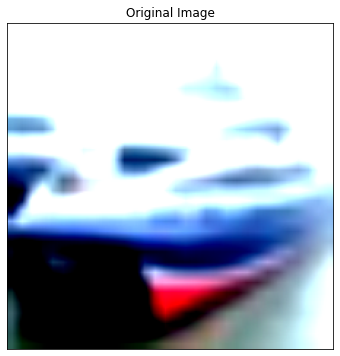

Sensitivity Max: 0.7647814750671387


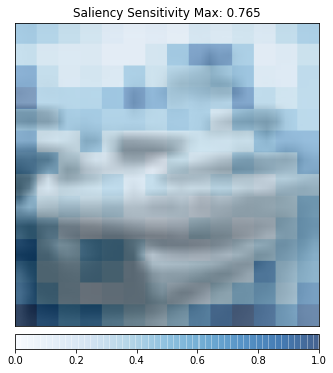

Sensitivity Max: 1.0065017938613892


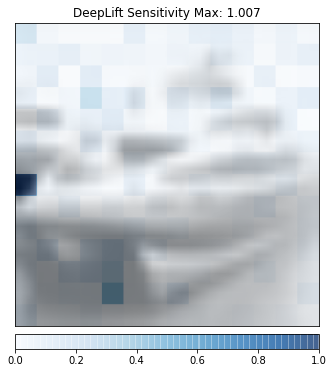

Sensitivity Max: 0.991


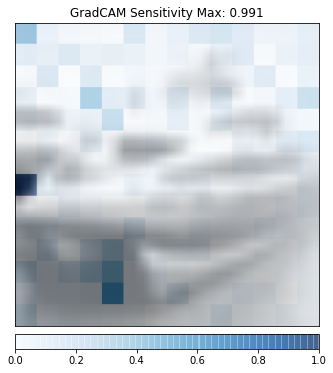

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcfb4436370>)

In [ ]:
import torchshow as ts
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
dim=768
ind=1

original_image = np.transpose((imgs[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

# Saliency                                                                       
attribution_saliency_vis = model_mae.unpatchify(model_mae.patchify(attribution_saliency).mean(-1,keepdim=True).repeat([1,1,dim]))
attribution_saliency_vis = np.transpose(attribution_saliency_vis[ind].squeeze(0).cpu().detach().numpy(), (1, 2, 0))
sens = sensitivity_max(saliency.attribute,imgs[ind].unsqueeze(0),target = labels.squeeze()[ind])
print('Sensitivity Max: '+ str(sens.item()))
viz.visualize_image_attr(attribution_saliency_vis, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Saliency " + 'Sensitivity Max: '+ str(round(sens.item(),3)))

# DeepLift
attribution_dl_vis = model_mae.unpatchify(model_mae.patchify(attribution_dl).mean(-1,keepdim=True).repeat([1,1,dim]))
attribution_dl_vis = np.transpose(attribution_dl_vis[ind].squeeze(0).cpu().detach().numpy(), (1, 2, 0))
sens = sensitivity_max(dl.attribute,imgs[ind].unsqueeze(0),target = labels.squeeze()[ind])
print('Sensitivity Max: '+ str(sens.item()))
viz.visualize_image_attr(attribution_dl_vis, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="DeepLift " + 'Sensitivity Max: '+ str(round(sens.item(),3)))


attribution_gdp_vis = model_mae.unpatchify(model_mae.patchify(attribution_gdp).mean(-1,keepdim=True).repeat([1,1,dim]))
attribution_gdp_vis = np.transpose(attribution_gdp_vis[ind].squeeze(0).cpu().detach().numpy(), (1, 2, 0))
sens = sensitivity_max(gbp.attribute,imgs[ind].unsqueeze(0),target = labels.squeeze()[ind])
print('Sensitivity Max: '+ str(round(sens.item(),3)))
viz.visualize_image_attr(attribution_gdp_vis, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="GradCAM " + 'Sensitivity Max: '+ str(round(sens.item(),3)))

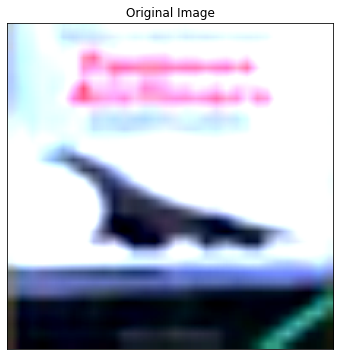

Sensitivity Max: 0.720311164855957


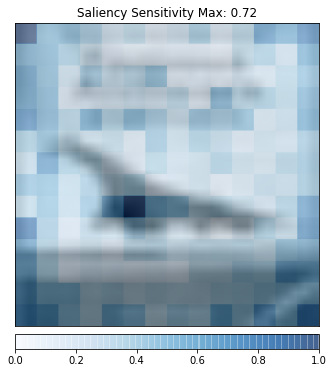

Sensitivity Max: 0.9553344249725342


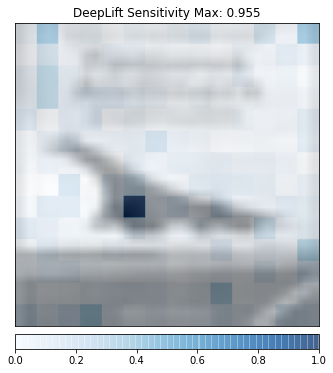

Sensitivity Max: 0.957


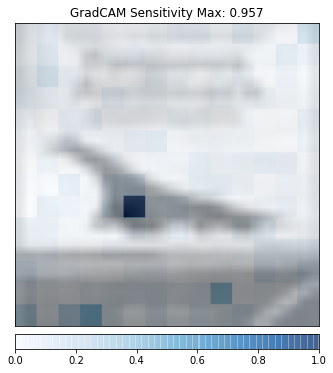

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf02cdc9a0>)

In [ ]:
import torchshow as ts
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
dim=768
ind=3

original_image = np.transpose((imgs[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

# Saliency                                                                       
attribution_saliency_vis = model_mae.unpatchify(model_mae.patchify(attribution_saliency).mean(-1,keepdim=True).repeat([1,1,dim]))
attribution_saliency_vis = np.transpose(attribution_saliency_vis[ind].squeeze(0).cpu().detach().numpy(), (1, 2, 0))
sens = sensitivity_max(saliency.attribute,imgs[ind].unsqueeze(0),target = labels.squeeze()[ind])
print('Sensitivity Max: '+ str(sens.item()))
viz.visualize_image_attr(attribution_saliency_vis, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Saliency " + 'Sensitivity Max: '+ str(round(sens.item(),3)))

# DeepLift
attribution_dl_vis = model_mae.unpatchify(model_mae.patchify(attribution_dl).mean(-1,keepdim=True).repeat([1,1,dim]))
attribution_dl_vis = np.transpose(attribution_dl_vis[ind].squeeze(0).cpu().detach().numpy(), (1, 2, 0))
sens = sensitivity_max(dl.attribute,imgs[ind].unsqueeze(0),target = labels.squeeze()[ind])
print('Sensitivity Max: '+ str(sens.item()))
viz.visualize_image_attr(attribution_dl_vis, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="DeepLift " + 'Sensitivity Max: '+ str(round(sens.item(),3)))


attribution_gdp_vis = model_mae.unpatchify(model_mae.patchify(attribution_gdp).mean(-1,keepdim=True).repeat([1,1,dim]))
attribution_gdp_vis = np.transpose(attribution_gdp_vis[ind].squeeze(0).cpu().detach().numpy(), (1, 2, 0))
sens = sensitivity_max(gbp.attribute,imgs[ind].unsqueeze(0),target = labels.squeeze()[ind])
print('Sensitivity Max: '+ str(round(sens.item(),3)))
viz.visualize_image_attr(attribution_gdp_vis, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="GradCAM " + 'Sensitivity Max: '+ str(round(sens.item(),3)))

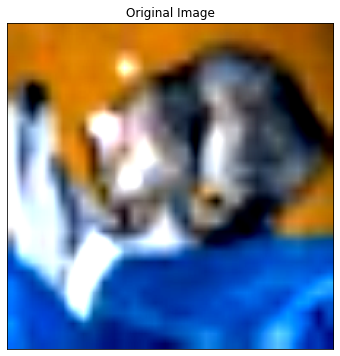

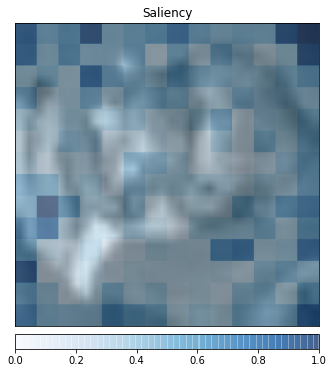

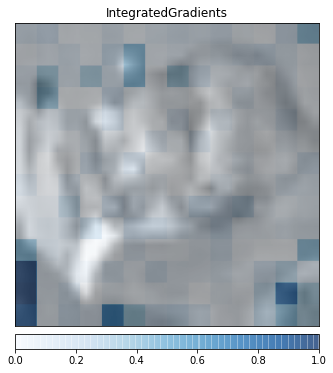

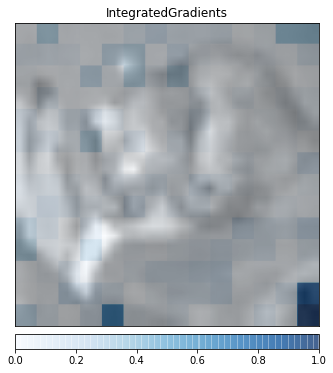

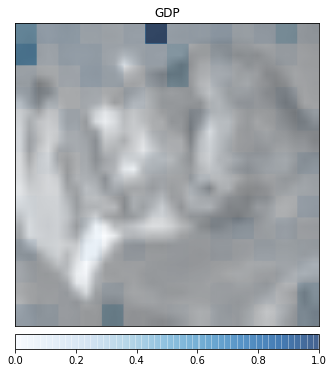

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4b2a16da00>)

In [ ]:
import torchshow as ts
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
dim=768
ind=2

original_image = np.transpose((imgs[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

# Saliency                                                                       
attribution_saliency_vis = model_mae.unpatchify(model_mae.patchify(attribution_saliency).mean(-1,keepdim=True).repeat([1,1,dim]))
attribution_saliency_vis = np.transpose(attribution_saliency_vis[ind].squeeze(0).cpu().detach().numpy(), (1, 2, 0))
viz.visualize_image_attr(attribution_saliency_vis, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Saliency")

# IG
attribution_ig_vis = model_mae.unpatchify(model_mae.patchify(attribution_ig).mean(-1,keepdim=True).repeat([1,1,dim]))
attribution_ig_vis = np.transpose(attribution_ig_vis[ind].squeeze(0).cpu().detach().numpy(), (1, 2, 0))
viz.visualize_image_attr(attribution_ig_vis, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="GradCAM")

# DeepLift
attribution_dl_vis = model_mae.unpatchify(model_mae.patchify(attribution_dl).mean(-1,keepdim=True).repeat([1,1,dim]))
attribution_dl_vis = np.transpose(attribution_dl_vis[ind].squeeze(0).cpu().detach().numpy(), (1, 2, 0))
viz.visualize_image_attr(attribution_dl_vis, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="DeepLift")


# gdp
attribution_gdp_vis = model_mae.unpatchify(model_mae.patchify(attribution_gdp).mean(-1,keepdim=True).repeat([1,1,dim]))
attribution_gdp_vis = np.transpose(attribution_gdp_vis[ind].squeeze(0).cpu().detach().numpy(), (1, 2, 0))
viz.visualize_image_attr(attribution_gdp_vis, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="GDP")

# MedMNIST

In [ ]:
import medmnist
from medmnist import INFO, Evaluator
# info = INFO['dermamnist']
info = INFO['bloodmnist']
info = INFO['retinamnist']
DataClass = getattr(medmnist, info['python_class'])

n_channels = info['n_channels']
n_classes = len(info['label'])
input_size = 224
import torchvision.transforms as transforms
import torchvision.datasets as datasets
train_num = 1000

if n_channels == 3:
    data_transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5])
    ])
else:
    data_transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[.5], std=[.5])
    ])

train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)
train_dataset,_ = torch.utils.data.random_split(train_dataset,[train_num,len(train_dataset)-train_num])

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=14
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=14
)

  0%|          | 0/3291041 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/retinamnist.npz


In [ ]:
"""
Finetune
"""
def accuracy(output, target, topk=(1,)):
    
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

# load model
model_mae = prepare_model(chkpt_dir, 'mae_vit_base_patch16')
model_mae.eval()
model_mae.to(device)
adapter = FT_Adapter(embed_dim=768,num_classes=n_classes)
adapter.to(device)
optimizer = torch.optim.Adam(adapter.parameters(),lr=0.001)
use_global_avg = True
criterion = torch.nn.CrossEntropyLoss()
epoch_num = 20
acc_lst = []

for epoch in range(epoch_num):
  acc = 0
  for i, (input, target) in enumerate(train_dataloader):
    input, target = input.to(device), target.to(device)
    with torch.no_grad():
      feats,_,_ = model_mae.forward_encoder(input,0)
      if use_global_avg:
        feats = feats[:, 1:, :].mean(dim=1)
      else:
        feats = feats[:, 0]

    pre = adapter(feats)
    loss = criterion(pre, target.squeeze())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    acc += accuracy(pre, target)[0]
  acc = acc / (i+1)
  acc_lst.append(acc.item())
  print('Epoch: '+str(epoch))
  print('Acc: ' + str(acc.item()))

<All keys matched successfully>
Epoch: 0
Acc: 41.732818603515625
Epoch: 1
Acc: 45.1058235168457
Epoch: 2
Acc: 45.899471282958984
Epoch: 3
Acc: 47.08995056152344
Epoch: 4
Acc: 48.7103157043457
Epoch: 5
Acc: 48.51190948486328
Epoch: 6
Acc: 49.00794219970703
Epoch: 7
Acc: 49.107147216796875
Epoch: 8
Acc: 49.7023811340332
Epoch: 9
Acc: 49.503971099853516
Epoch: 10
Acc: 49.60317611694336
Epoch: 11
Acc: 49.7023811340332
Epoch: 12
Acc: 49.503971099853516
Epoch: 13
Acc: 49.80158996582031
Epoch: 14
Acc: 49.7023811340332
Epoch: 15
Acc: 49.900794982910156
Epoch: 16
Acc: 49.80158996582031
Epoch: 17
Acc: 49.80158996582031
Epoch: 18
Acc: 49.7023811340332
Epoch: 19
Acc: 49.7023811340332


Text(0, 0.5, 'Acc')

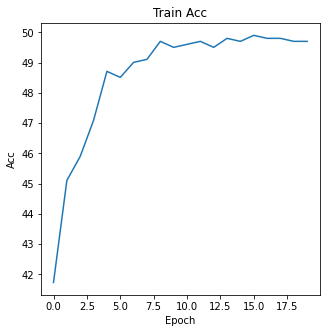

In [ ]:
plt.figure(figsize=[5,5])
plt.plot([i for i in range(epoch_num)],acc_lst)
plt.title('Train Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')

In [ ]:
vis_num = 4
com_model = CombineModel(model_mae,adapter,False)

imgs,labels = next(iter(test_dataloader))
imgs = imgs[:vis_num].cuda()
labels = labels[:vis_num].cuda()

# ig
# ig = IntegratedGradients(com_model)
# attribution_ig = ig.attribute(imgs, target=labels.squeeze())

# saliency
saliency = Saliency(com_model)
attribution_saliency = saliency.attribute(imgs, target=labels.squeeze())

# gdp
gbp = GuidedBackprop(com_model)
attribution_gdp = gbp.attribute(imgs, target=labels.squeeze())

# deeplift
dl = DeepLift(com_model)
attribution_dl = dl.attribute(imgs, target=labels.squeeze())

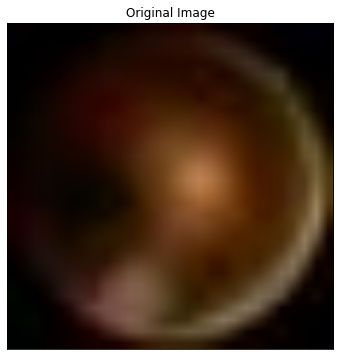

Sensitivity Max: 0.8907266855239868


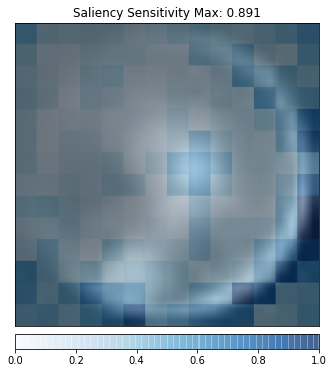

Sensitivity Max: 1.3126306533813477


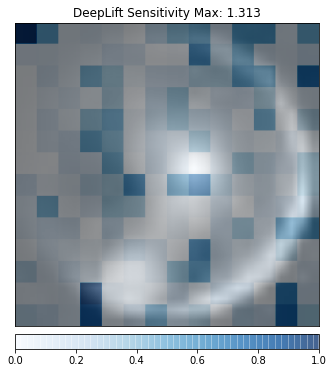

Sensitivity Max: 1.283


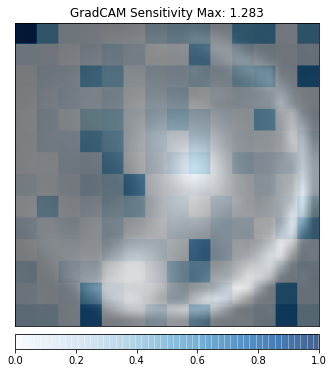

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcfb43af400>)

In [ ]:
import torchshow as ts
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
dim=768
ind=1

original_image = np.transpose((imgs[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

# Saliency                                                                       
attribution_saliency_vis = model_mae.unpatchify(model_mae.patchify(attribution_saliency).mean(-1,keepdim=True).repeat([1,1,dim]))
attribution_saliency_vis = np.transpose(attribution_saliency_vis[ind].squeeze(0).cpu().detach().numpy(), (1, 2, 0))
sens = sensitivity_max(saliency.attribute,imgs[ind].unsqueeze(0),target = labels.squeeze()[ind])
print('Sensitivity Max: '+ str(sens.item()))
viz.visualize_image_attr(attribution_saliency_vis, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Saliency " + 'Sensitivity Max: '+ str(round(sens.item(),3)))

# DeepLift
attribution_dl_vis = model_mae.unpatchify(model_mae.patchify(attribution_dl).mean(-1,keepdim=True).repeat([1,1,dim]))
attribution_dl_vis = np.transpose(attribution_dl_vis[ind].squeeze(0).cpu().detach().numpy(), (1, 2, 0))
sens = sensitivity_max(dl.attribute,imgs[ind].unsqueeze(0),target = labels.squeeze()[ind])
print('Sensitivity Max: '+ str(sens.item()))
viz.visualize_image_attr(attribution_dl_vis, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="DeepLift " + 'Sensitivity Max: '+ str(round(sens.item(),3)))


attribution_gdp_vis = model_mae.unpatchify(model_mae.patchify(attribution_gdp).mean(-1,keepdim=True).repeat([1,1,dim]))
attribution_gdp_vis = np.transpose(attribution_gdp_vis[ind].squeeze(0).cpu().detach().numpy(), (1, 2, 0))
sens = sensitivity_max(gbp.attribute,imgs[ind].unsqueeze(0),target = labels.squeeze()[ind])
print('Sensitivity Max: '+ str(round(sens.item(),3)))
viz.visualize_image_attr(attribution_gdp_vis, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="GradCAM " + 'Sensitivity Max: '+ str(round(sens.item(),3)))

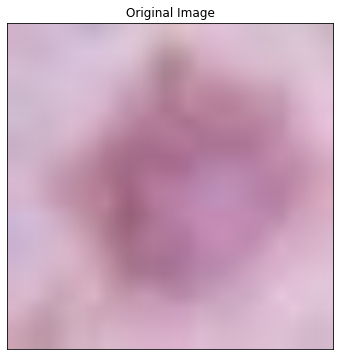

/usr/local/lib/python3.8/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Sensitivity Max: 1.0877645015716553


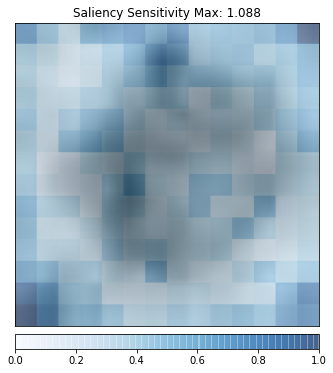

/usr/local/lib/python3.8/dist-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Sensitivity Max: 1.681061863899231


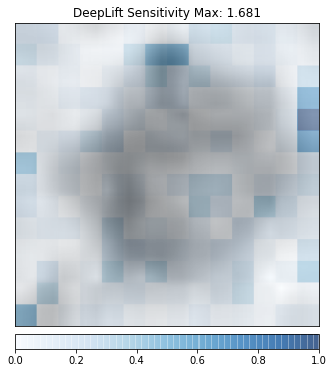

/usr/local/lib/python3.8/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


Sensitivity Max: 1.604


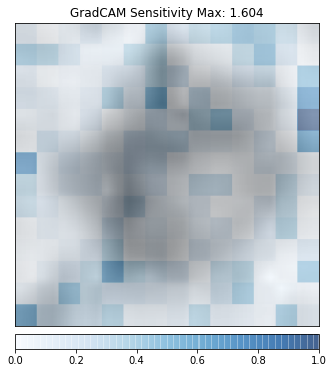

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcfb4351af0>)

In [ ]:
import torchshow as ts
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
dim=768
ind=1

original_image = np.transpose((imgs[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

# Saliency                                                                       
attribution_saliency_vis = model_mae.unpatchify(model_mae.patchify(attribution_saliency).mean(-1,keepdim=True).repeat([1,1,dim]))
attribution_saliency_vis = np.transpose(attribution_saliency_vis[ind].squeeze(0).cpu().detach().numpy(), (1, 2, 0))
sens = sensitivity_max(saliency.attribute,imgs[ind].unsqueeze(0),target = labels.squeeze()[ind])
print('Sensitivity Max: '+ str(sens.item()))
viz.visualize_image_attr(attribution_saliency_vis, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Saliency " + 'Sensitivity Max: '+ str(round(sens.item(),3)))

# DeepLift
attribution_dl_vis = model_mae.unpatchify(model_mae.patchify(attribution_dl).mean(-1,keepdim=True).repeat([1,1,dim]))
attribution_dl_vis = np.transpose(attribution_dl_vis[ind].squeeze(0).cpu().detach().numpy(), (1, 2, 0))
sens = sensitivity_max(dl.attribute,imgs[ind].unsqueeze(0),target = labels.squeeze()[ind])
print('Sensitivity Max: '+ str(sens.item()))
viz.visualize_image_attr(attribution_dl_vis, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="DeepLift " + 'Sensitivity Max: '+ str(round(sens.item(),3)))


attribution_gdp_vis = model_mae.unpatchify(model_mae.patchify(attribution_gdp).mean(-1,keepdim=True).repeat([1,1,dim]))
attribution_gdp_vis = np.transpose(attribution_gdp_vis[ind].squeeze(0).cpu().detach().numpy(), (1, 2, 0))
sens = sensitivity_max(gbp.attribute,imgs[ind].unsqueeze(0),target = labels.squeeze()[ind])
print('Sensitivity Max: '+ str(round(sens.item(),3)))
viz.visualize_image_attr(attribution_gdp_vis, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="GradCAM " + 'Sensitivity Max: '+ str(round(sens.item(),3)))


In [ ]:
imgs.shape

torch.Size([4, 3, 224, 224])

In [ ]:
!sudo fuser /dev/nvidia*

/dev/nvidia0:          676m
/dev/nvidiactl:        676m
/dev/nvidia-uvm:       676m


In [ ]:
!kill -9 676

In [ ]:
torch.nn.functional.one_hot(labels.squeeze(1),n_classes).shape

torch.Size([4, 7])

In [ ]:
next(iter(test_dataloader))[-1].shape

torch.Size([28])

In [ ]:
imgs[ind].unsqueeze(0).shape

torch.Size([1, 3, 224, 224])